# Imports

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys
import struct
import time
import pandas as pd

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm

%matplotlib inline

In [2]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data/"
BETAS_PATH = NSD_ROOT+"/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/"


DEVICE = 'cpu'

Generating image maps for low level image features, such as contrast (using edges), saturation, luminance, etc.

These maps can the be used to compare their correlation with saliency maps, and see how much effect do low level features have on the correlations, for each ROI.


# Import images and indices

In [3]:
BEHAV_PATH = NSD_ROOT + "/nsddata/ppdata/subj01/behav/responses.tsv"

In [4]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')
    resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
    resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1.head()

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,1,1,1,1,46002,625,0.505082,0,1.0,803.529781,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,1,1,1,2,61882,5012,0.505128,0,1.0,972.261383,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,1,1,1,3,828,4849,0.505175,0,1.0,742.351236,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,1,1,1,4,67573,8822,0.505221,0,1.0,747.518479,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,1,1,1,5,16020,9537,0.505267,0,1.0,547.422774,0.0,NaN,NaN,0,1.0,1,0,1.0,0


In [5]:
img_indices = resp_subj1['73KID']


In [6]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data_73k = np.copy(image_data_set['imgBrick'])
image_data_set.close()## Load images 

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [8]:
# check how many times an image is shown 
resp_subj1['73KID'].value_counts()

46002    3
55872    3
32024    3
64987    3
8625     3
        ..
15390    3
41778    3
60016    3
5823     3
37846    3
Name: 73KID, Length: 10000, dtype: int64

In [9]:
import cv2 as cv

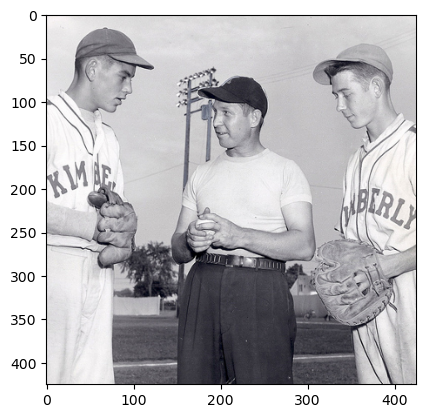

In [33]:
img= image_data_73k[6]
plt.imshow(img);

In [11]:
def generate_maps_dict(map_type, img_indices, num_pixels = 425, kernel_size = None):
    '''
    Generate a dictionary containing the required low-level feature map for an image 
    
    '''
    maps_dict = {} 
    
    for idx in tqdm(img_indices): 
        
        if idx in maps_dict: 
            continue
        
        else: 
            image = image_data_73k[idx]
            
            if map_type == 'edge':
                img_map = generate_edge_map_single(image, kernel_size) 
                
            elif map_type == 'saturation':
                img_map = generate_saturation_map_single(image) 
                
            elif map_type == 'luminance':
                img_map = generate_luminance_map_single(image)
                
            maps_dict[idx] = img_map
        
    return maps_dict

In [12]:
def convert_dict_to_S_mat(map_dict, img_indices, num_pixels = 425): 
    '''
    Convert the dictionary containing low-level feature maps into the S_mat format
    '''
    S_mat_full = np.ones([len(img_indices), num_pixels*num_pixels], dtype = 'float16')

    for trial_num, idx in enumerate(tqdm(img_indices)):
        
        S_map_img = map_dict[idx] 
        
        S_map_long = S_map_img.reshape(-1, num_pixels * num_pixels)
        
        S_mat_full[trial_num, :] = S_map_long
        
    return S_mat_full


# 1. Edge maps 

In [13]:
import argparse 
import cv2 

In [14]:
def generate_edge_map_single(image, kernel_size):
    
    if kernel_size == None: 
        raise ValueError("kernel_size not defined.") 
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5),0) # 5x5 gaussian filter, to reduce noise 
    laplacian = cv2.Laplacian(blurred, kernel_size, cv2.CV_64F)
    edge_map = cv2.convertScaleAbs(laplacian) 

    return edge_map


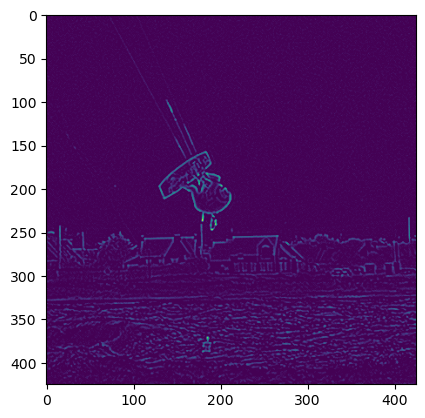

In [15]:
plt.imshow(generate_edge_map_single(img, 10))

In [16]:
edge_maps_dict = generate_maps_dict(map_type = 'edge', kernel_size = 10, img_indices = img_indices) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:31<00:00, 951.13it/s]


In [15]:
S_mat_edges = convert_dict_to_S_mat(edge_maps_dict, img_indices) 

100%|██████████| 30000/30000 [00:38<00:00, 775.60it/s]


In [16]:
# np.save(DATA_PATH+"/S_mat_edges.npy",S_mat_edges)

# 2. Saturation maps 

The HSV color space is less affected by variations in lighting conditions compared to the RGB color space and its independent color order provides more consistent and accurate color detection in an image.

In [18]:
def generate_saturation_map_single(img): 
    image_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    saturation_map = image_hsv[:,:,1]
    
    return saturation_map

In [19]:
img= image_data_73k[1]

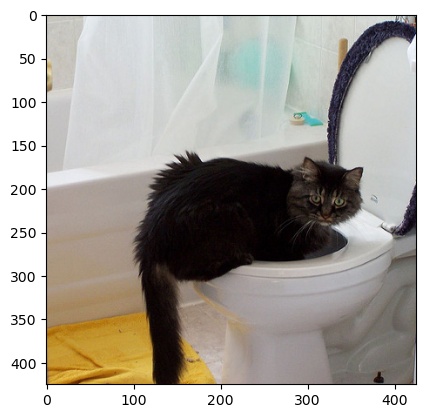

In [20]:
plt.imshow(img)

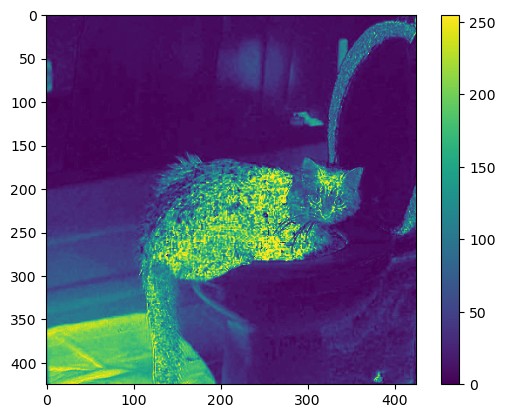

In [21]:
plt.imshow(generate_saturation_map_single(img)) 
plt.colorbar()

In [22]:
saturation_maps_dict = generate_maps_dict(map_type = 'saturation', img_indices = img_indices) 

100%|██████████| 30000/30000 [00:02<00:00, 11947.45it/s]


In [23]:
S_mat_saturation = convert_dict_to_S_mat(saturation_maps_dict, img_indices) 

100%|██████████| 30000/30000 [00:19<00:00, 1508.64it/s]


In [26]:
np.save(DATA_PATH+"/S_mat_saturation.npy",S_mat_saturation)

# 3. Luminance maps 

In [27]:
def generate_luminance_map_single(img): 
    image_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    luminance_map = image_hsv[:,:,2]
    
    return luminance_map

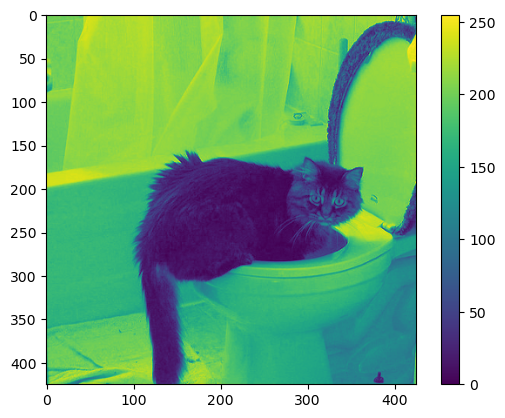

In [28]:
plt.imshow(generate_luminance_map_single(img)) ;
plt.colorbar();

In [29]:
luminance_maps_dict = generate_maps_dict(map_type = 'luminance', img_indices = img_indices) 

100%|██████████| 30000/30000 [00:02<00:00, 12064.00it/s]


In [30]:
S_mat_luminance = convert_dict_to_S_mat(luminance_maps_dict, img_indices) 

100%|██████████| 30000/30000 [00:20<00:00, 1451.72it/s]


In [31]:
np.save(DATA_PATH+"/S_mat_luminance.npy",S_mat_luminance)

In [ ]:


# # betas_big = 27750 x (0, 0, 0 ) --mask --> 27750 x (num of voxels) V1 4165 

# # betas-big   x (0, 0, 0 ) 

# imgeset_1 , imgset_2 , img-set_3 

# for each image in image-set_1 ; 
#     betas[idx, : ,: ,: ]
    
# for each image in image-set_2 ;
# for each image in image-set_3 ; 

In [18]:
# Read sal files generated by matlab 
import scipy.io

In [19]:
DATA_PATH

'/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data/'

In [20]:
mat_data_one = scipy.io.loadmat(DATA_PATH + "salmap.mat") 

In [21]:
mat_data = scipy.io.loadmat(DATA_PATH + "salmaps.mat")
mat_data_list = scipy.io.loadmat(DATA_PATH + "salmapslist.mat") 

In [26]:
mat_data_list["salmaplist"].shape

(392, 784)

In [22]:
mat_data_shaped = mat_data_list["salmaplist"].reshape(392,392,-1)

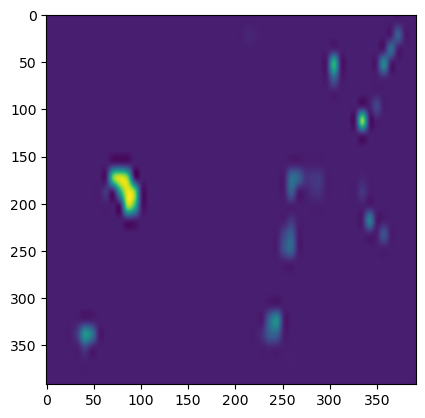

In [23]:
plt.imshow(mat_data_shaped[:,:,1])

In [27]:
mat_data_one['saliency_map']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
mat_data['salmaps'][0][1][2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08266347, 0.03406218, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.69287094, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08111016,
        0.        , 0.        , 0.        , 0.        , 0.        ,
      

In [ ]:
# TODO 

# fix that using makesaliency , the results are duplicated 
#. fix the dimension 392x392
# will have to reshape the dimension of the returned object, otherwise it's fine 